<a href="https://colab.research.google.com/github/cregnier31/IA-Project/blob/main/WORK_notebook_IA_project2_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import des données altimétriques

### Install dependencies

In [ ]:
!pip install xarray[complete] eccodes hvplot pytorch-lightning -q

### Download netcdfs

#### Download NATL60 data

In [ ]:
!wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

File ‘NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc’ already there; not retrieving.



#### Download pseudo observation data

In [ ]:
!wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/data/gridded_data_swot_wocorr/dataset_nadir_0d_swot.nc 


File ‘dataset_nadir_0d_swot.nc’ already there; not retrieving.



#### Download Duacs oi product made from pseudo observations

In [ ]:
!wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/oi/ssh_NATL60_swot_4nadir.nc

File ‘ssh_NATL60_swot_4nadir.nc’ already there; not retrieving.



## Read and visualize data

#### Imports

In [ ]:
import matplotlib.pyplot as plt # plotting library
import xarray as xr
import pandas as pd
import scipy.ndimage as ndi
import numpy as np
import holoviews as hv
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import pytorch_lightning as pl

from torch.utils.data import DataLoader,random_split
from torch.utils.data import random_split
from torchvision import transforms
from torchvision import datasets

from torch.utils.data.sampler import SubsetRandomSampler

/usr/local/lib/python3.7/dist-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


#### Read files

In [ ]:
ref_ds = xr.open_dataset('NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc', decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
oi_ds = xr.open_dataset('ssh_NATL60_swot_4nadir.nc')
obs_ds = xr.open_dataset('dataset_nadir_0d_swot.nc')

/usr/local/lib/python3.7/dist-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


#### Visualize fields

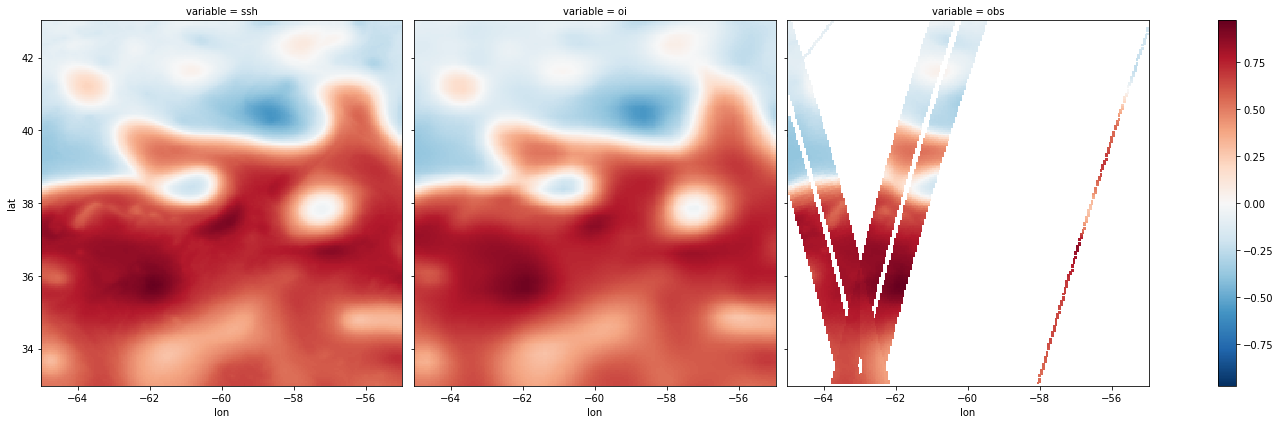

In [ ]:
xr.Dataset({
    'ssh': ref_ds.ssh,
    'oi': oi_ds.ssh_mod,
    'obs': obs_ds.ssh_mod,
}).to_array().isel(time=100).plot.pcolormesh(col='variable', figsize=(20, 6))

#### Visualize amplitude of the gradients

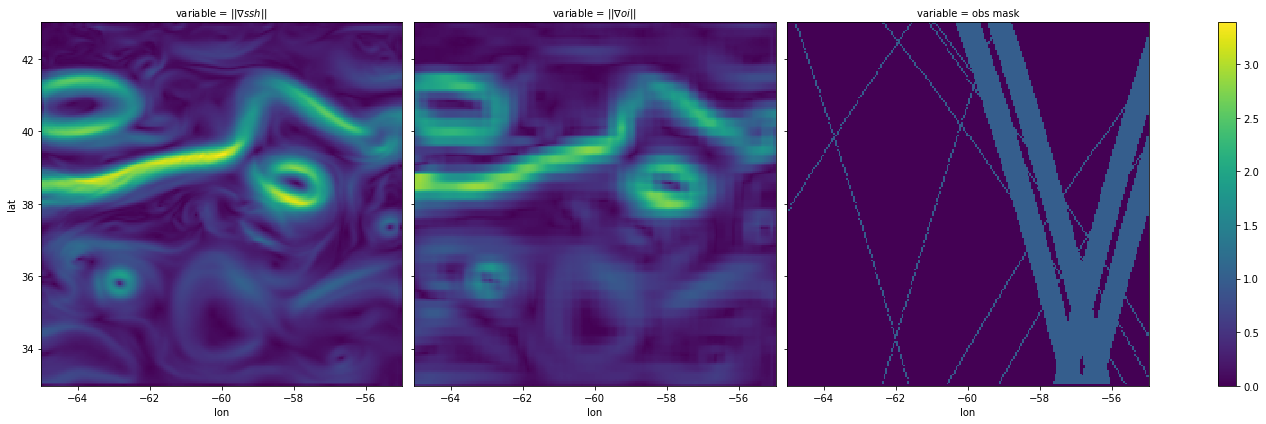

In [ ]:
def sobel(da):
    dx = xr.apply_ufunc(lambda _da: ndi.sobel(_da, -1), da)
    dy = xr.apply_ufunc(lambda _da: ndi.sobel(_da, -2), da)
    return np.hypot(dx, dy)

grad_ds = xr.Dataset({
    r'||$\nabla ssh||$': ref_ds.ssh.pipe(sobel),
    r'||$\nabla oi||$': oi_ds.ssh_mod.pipe(sobel),
    'obs mask': np.isfinite(obs_ds.ssh_mod),
})
grad_ds.to_array().isel(time=3).plot.pcolormesh(col='variable', figsize=(20, 6), cmap='viridis')

## Additional data

Here are the link from other files that may be of interest:

**Other quantities:**
- Sea surface temperature from NATL60 simulation: https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc
- Sea surface currents from NATL60 simulation: https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_sss_y2013.1y.nc


**Other observation configurations:**
- Nadirs only: 
  - obs: https://s3.us-east-1.wasabisys.com/melody/osse_data/data/gridded_data_swot_wocorr/dataset_nadir_0d.nc
  - oi: https://s3.us-east-1.wasabisys.com/melody/osse_data/oi/ssh_NATL60_4nadir.nc

- SWOT only:
  - obs: https://s3.us-east-1.wasabisys.com/melody/osse_data/data/gridded_data_swot_wocorr/dataset_swot.nc
  - oi: https://s3.us-east-1.wasabisys.com/melody/osse_data/oi/ssh_NATL60_swot.nc

#### **Dataloader creation** - Check data loader documentation ([documentation](https://pytorch.org/docs/stable/data.html)) for training, validation and test sets. <a class="anchor" id="question_1_2"></a>

In [ ]:
# Define train data and test data
window_size = 9 # Size of temporal window of each sample

# Initialize of data

# Pseudo obs.
datax = obs_ds.ssh_mod.data

# NATL 60
datay = ref_ds.ssh.data

# Optimal interp aviso 
datax2 = oi_ds.ssh_mod.data 

# Define function
def data_formater(data) :

  # Define shapes
  # input_shape = list(data.shape)
  # out_shape = input_shape.insert(1,window_size)

  # Fill nan with zeros
  data[np.isnan(data)] = 0.

  return data


def time_channels_x(data, window_size):
    """
    Create x data with time channels.
    """

    if (window_size % 2) == 0:
        raise ValueError('window size must be odd')

    data_copy = np.squeeze(data)
    shape = list(data_copy.shape)
    shape[0] -= (window_size - 1)
    shape.insert(1, window_size)
    array = np.zeros(shape)

    for time in range(shape[0]) :
        array[time, :, :, :] = data[time: time+window_size, :, :]

    return torch.Tensor(array)

def time_channels_y(data, window_size):
    """
    Create y data correponding to x input.
    """
    if (window_size % 2) == 0:
        raise ValueError('window size must be odd')

    half_window = (window_size -1)//2
    data_copy = np.squeeze(data)
    array = data_copy[half_window : -half_window,:,:]

    return torch.Tensor(array)

   
# time channels = 1
#datax = data_formater(datax)
#datax2 = data_formater(datax2)
#datay = data_formater(datay)

window_size = 7

datax = time_channels_x(datax, window_size)
datax2 = time_channels_x(datax2, window_size)
datay = time_channels_y(datay, window_size)

# TO DO 
x1 = torch.Tensor(datax)
#x1 = torch.unsqueeze(x1, 1)  # uncomment with time channel = 1
print(f'{np.shape(x1)}')
x2 = torch.Tensor(datax2)
#x2 = torch.unsqueeze(x2, 1)  # uncomment with time channel = 1
print(f'{np.shape(x2)}')
y = torch.Tensor(datay)
y = torch.unsqueeze(y, 1)
print(f'{np.shape(y)}')


x = torch.cat((x1, x2), 1)
print(f'{np.shape(x)}')

train_data = torch.utils.data.TensorDataset(x, y)
#print(train_data.tensors[0])
#print(train_data.tensors[1])

#x1test = torch.Tensor(obs_ds.ssh_mod.data[:20,:,:])
#x1test = torch.unsqueeze(x1test, 1)
#x2test = torch.Tensor(oi_ds.ssh_mod.data[:20,:,:])
#x2test = torch.unsqueeze(x2test, 1)

x1test = time_channels_x(obs_ds.ssh_mod.data[:20,:,:], window_size)
x2test = time_channels_x(oi_ds.ssh_mod.data[:20,:,:], window_size)
ytest = time_channels_y(ref_ds.ssh.data[:20,:,:], window_size)

xtest = torch.cat((x1test, x2test), 1)
print(f'{np.shape(xtest)}')
#ytest = torch.Tensor(ref_ds.ssh.data[:20,:,:])
ytest = torch.unsqueeze(ytest, 1)
test_data = torch.utils.data.TensorDataset(xtest, ytest)

torch.Size([359, 7, 201, 201])
torch.Size([359, 7, 201, 201])
torch.Size([359, 1, 201, 201])
torch.Size([359, 14, 201, 201])
torch.Size([14, 14, 201, 201])


In [ ]:
ytest.shape

torch.Size([20, 1, 201, 201])

In [ ]:
# Define parameters
batch_size = 20 # IF DOES NOT WORK ==> DOWN UP TO 2
valid_size = 0.2
train_size = 0.8

def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED

  num_train = len(train_data)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  nb_train = int( np.floor(train_size * num_train ))
  split = int(np.floor(valid_size * num_train))
  #print(nb_train, split)
  train_index, valid_index = indices[split:nb_train], indices[:split]

  train_sampler = SubsetRandomSampler(train_index)
  valid_sampler = SubsetRandomSampler(valid_index)

  train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler, shuffle=False)
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=False)

  return train_loader, valid_loader, test_loader

In [ ]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) # TO DO

In [ ]:
#test_loader.dataset
len(list(train_loader))
train_loader.__dict__.keys()
len(train_loader.dataset.tensors)

2

## Our CNN <a class="anchor" id="section_2"></a>

**CNN architecture** - Define a CNN architecture with at least one layer. <a class="anchor" id="question_2_1"></a>

In [ ]:
rateDropout = 0.2
padding_mode = 'reflect'


class DoubleConvBILIN(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None,padding_mode='reflect'):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
            
        self.conv1  = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode)
        self.conv21 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode)
        self.conv22 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode)
        self.conv23 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode)
        self.conv24 = nn.Conv2d(2*mid_channels, out_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode)

        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = F.relu( self.bn1(x1) )
        
        x11 = self.conv21(x1) 
        x12 = self.conv22(x1) 
        x13 = self.conv23(x1) 
        x1 = self.conv24( torch.cat((x11,x12*x13),dim=1) )
        
        x1 = self.bn2(x1)
        
        return x1

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None,padding_mode='reflect',activation='relu'):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
            
        if activation == 'relu':
            self.double_conv = nn.Sequential(
                    nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode),
                    nn.BatchNorm2d(mid_channels),
                    nn.ReLU(inplace=True),
                    nn.Dropout(rateDropout),
                    nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True)
                )
        elif activation == 'tanh' :
            self.double_conv = nn.Sequential(
                    nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode),
                    nn.BatchNorm2d(mid_channels),
                    nn.Tanh(inplace=True),
                    nn.Dropout(rateDropout),
                    nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode),
                    nn.BatchNorm2d(out_channels),
                    nn.Tanh(inplace=True) )
        elif activation == 'logsigmoid' :
            self.double_conv = nn.Sequential(
                    nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode),
                    nn.BatchNorm2d(mid_channels),
                    nn.LogSigmoid(inplace=True),
                    nn.Dropout(rateDropout),
                    nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False,padding_mode=padding_mode),
                    nn.BatchNorm2d(out_channels),
                    nn.LogSigmoid(inplace=True) )
        elif activation == 'bilin' :
            self.double_conv = DoubleConvBILIN(in_channels, mid_channels,padding_mode=padding_mode)

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            #nn.AvgPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class CNN(nn.Module):

    def __init__(self, in_channels):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        #self.maxp1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, stride=1, padding=2) # subwindow = 3-5 days

    def forward(self,x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.conv4(out)
        return out


class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        
        #self.down4 = Down(512, 1024 // factor)
        #self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)

        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        out = self.outc(x)
        
        return out


class LitModel(pl.LightningModule):
    def __init__(self, model_name, n_channels = 1):
        super().__init__()

        if model_name == 'cnn':
            self.model = CNN(n_channels)
        elif model_name == 'unet':
            self.model = UNet2(n_channels = n_channels, n_classes = 1)
        else:
          raise Exception(f'Unknown model {model_name}')
  
        self.criterion = nn.MSELoss()
        self.test_data = None # used afterwards for the results

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self(data)
        loss = self.criterion(output, label)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx): ## TODO 1
        data, label = batch
        output = self(data)
        loss = self.criterion(output, label)
        self.log('val_loss', loss) ## TODO 3
        return loss
          
    def configure_optimizers(self): ## TODO 1
        return torch.optim.Adam(self.parameters(),lr = 0.001) 

    def test_step(self, batch, batch_idx): ## TODO 5
        data, label = batch
        output = self(data)
        loss = self.criterion(output, label)
        self.log('test_loss', loss)

        preds = torch.max(output.cpu(), 1)[1]
        return label.cpu(), preds

    def test_epoch_end(self, test_step_outputs): ## TODO 5
        list_of_labels, list_of_preds = zip(*test_step_outputs)
        labels, preds = torch.cat(list_of_labels),  torch.cat(list_of_preds)
        
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        correct = np.squeeze(preds.eq(labels.data.view_as(preds)))
        for i in range(len(labels)):
            digit = labels.data[i]
            class_correct[digit] += correct[i].item()
            class_total[digit] += 1

        for i in range(10):
            print('test accuracy of %s: %2d%% (%2d/%2d)' 
                % (i, 100 * class_correct[i] / class_total[i],
                   np.sum(class_correct[i]), np.sum(class_total[i])))

        print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)'
             % (100. * np.sum(class_correct) / np.sum(class_total),
                np.sum(class_correct), np.sum(class_total)))

        self.test_data = labels, preds 

In [ ]:
model_name = 'cnn'


cnn_model = LitModel(model_name, n_channels = 14)
cnn_model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss')
cnn_logger = pl.loggers.CSVLogger('logs', name='cnn_mnist') 
cnn_trainer = pl.Trainer(
    gpus=1, 
    max_epochs=30,
    callbacks=[cnn_model_checkpoint],
    logger=cnn_logger,
    accelerator="auto"
  )

cnn_trainer.fit(cnn_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

print(f"\n\n>>>>>>>>>>>>>   Logs stored at {cnn_logger.log_dir}/metrics.csv")
print(f"""\n>>>>>>>>>>>>    Best model saved at {cnn_model_checkpoint.best_model_path}
    with validation loss {cnn_model_checkpoint.best_model_score}""")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params
--------------------------------------
0 | model     | CNN     | 114 K 
1 | criterion | MSELoss | 0     
--------------------------------------
114 K     Trainable params
0         Non-trainable params
114 K     Total params
0.458     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.




>>>>>>>>>>>>>   Logs stored at logs/cnn_mnist/version_13/metrics.csv

>>>>>>>>>>>>    Best model saved at logs/cnn_mnist/version_13/checkpoints/epoch=28-step=319.ckpt
    with validation loss 0.002706855535507202


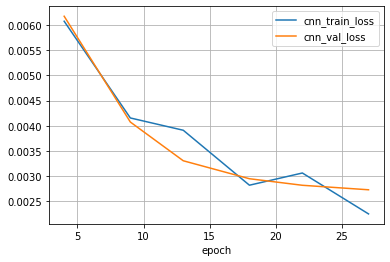

In [ ]:
cnn_training_metrics_df = (
    pd.read_csv(f'{cnn_logger.log_dir}/metrics.csv') .groupby('epoch').mean()
    [['train_loss', 'val_loss']].rename(lambda col_name: f'cnn_{col_name}', axis=1).dropna()
)
cnn_training_metrics_df.plot(grid=True)

### Load best model and display accuracy per digit


In [ ]:
print("\n\n############## CNN #############\n")
best_cnn = cnn_model.load_from_checkpoint(cnn_model_checkpoint.best_model_path, model_name='cnn')
cnn_trainer.test(best_cnn, dataloaders=test_loader)



############## CNN #############



RuntimeError: ignored

### Display confusion matrices


In [ ]:
import sklearn.metrics
cnn_labels, cnn_preds = best_cnn.test_data

fig, ax_cnn = plt.subplots(1,1, figsize=(13, 6))
ax_cnn.set_title('CNN')

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(cnn_labels, cnn_preds, cmap='Blues', ax=ax_cnn, colorbar=False)

In [ ]:
def get_all_prediction(model, loader): # FUNCTION TO BE COMPLETED
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [ ]:
test_loader

In [ ]:
#targets, preds = get_all_prediction(cnn_model, train_loader)
#preds = cnn_model(next(iter(train_loader))[0][0]).squeeze()

# temporal index
idx = 300

# Prediction for UNet2 (noiser than CNN outcome, why?)
if model_name == 'unet':
    preds = cnn_model(train_loader.dataset.tensors[0][idx:idx+1, :, :, :])[0].squeeze()

# Prediction for CNN 
elif model_name == 'cnn':
    preds = cnn_model(train_loader.dataset.tensors[0][idx, :, :]).squeeze()



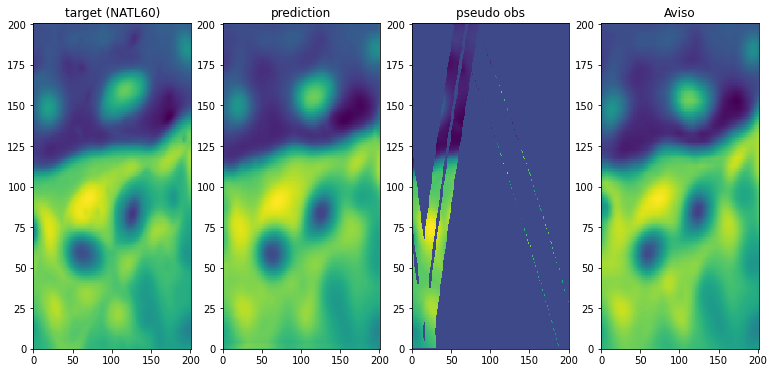

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 6))

ax1.set_title('target (NATL60)')
ax1.pcolormesh(train_loader.dataset.tensors[1][idx,:,:].squeeze())

ax2.set_title('prediction')
ax2.pcolormesh(preds.detach().numpy())

ax3.set_title('pseudo obs')
ax3.pcolormesh(train_loader.dataset.tensors[0][idx][0,:,:])

ax4.set_title('Aviso')
ax4.pcolormesh(train_loader.dataset.tensors[0][idx][-1,:,:])
#x2.pcolormesh(next(iter(train_loader))[0][0][1].squeeze())

#ax1.pcolormesh(next(iter(train_loader))[0][0][0].squeeze())
#x2.pcolormesh(next(iter(train_loader))[0][0][1].squeeze())